## Import necessary packages

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from utils import *
from model import SiameseNetwork
from loss import ContrastiveLoss
from dataset import ATATContrast
from torchsummary import summary
from matplotlib import pyplot as plt
import os
from glob import glob
import random
from sklearn.metrics import classification_report
import shutil
from tqdm import tqdm

# Prepare the data file

In [2]:
os.mkdir("train_test_val")
os.mkdir("train_test_val/train")
os.mkdir("train_test_val/test")
os.mkdir("train_test_val/val")

data=os.listdir("../archive (2)")
data.remove("README")

#train
rs=random.sample(data,32)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/train/{i}")
    data.remove(i)

#test
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/test/{i}")
    data.remove(i)

#valid
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/valid/{i}")
    data.remove(i)

In [3]:
# os.mkdir("train_test_val")
# os.mkdir("train_test_val/train")
# os.mkdir("train_test_val/test")
# os.mkdir("train_test_val/val")

# for i in ["train","test","val"]:
#     for j in range(1,41):
#         os.mkdir(f"train_test_val/{i}/s{j}")
        
        
# for i in os.listdir("../archive (2)"):
#     if i == ".DS_Store":
#         continue
#     if i =="README":
#         continue
    
#     images=glob(f"../archive (2)/{i}/*.pgm")
    

#     #train
#     for img in random.sample(images, 6):
#         shutil.copyfile(img, f"train_test_val/train/{i}/{img.split('/')[-1]}")
#         images.remove(img)
        
#     #test
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/test/{i}/{img.split('/')[-1]}")
#         images.remove(img)
    
#     #val
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/val/{i}/{img.split('/')[-1]}")
#         images.remove(img)
    
    

## Initialize batch size and hyperparameters
The margin and threshold were changed to perform well on the validation set

In [4]:
path = 'train_test_val'

## Initialize parameters
bs = 32
lr = 1e-3
threshold = 0.1
margin = 1.0
epochs = 20

## Initialize network variables

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("the device being used is:",device)

## Initialize network
model = SiameseNetwork()
model = model.to(device)

model.apply(initialize_weights)

## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optim,5,gamma=0.7)

## Initialize loss
criterion = ContrastiveLoss(margin)

the device being used is: mps


## Create Datasets and Dataloaders

In [6]:
## Initialize datasets and dataloaders
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(25),
            # torchvision.transforms.Resize((200,100)),
            torchvision.transforms.ToTensor()
        ])

valid_transforms = torchvision.transforms.Compose([
            # torchvision.transforms.Resize((200,100)),
            torchvision.transforms.ToTensor()
        ])

test_transforms = torchvision.transforms.Compose([
            # torchvision.transforms.Resize((200,100)),
            torchvision.transforms.ToTensor()
        ])

train_ds = ATATContrast(ImageFolder(root = path + '/train',transform=train_transforms))
valid_ds = ATATContrast(ImageFolder(root = path + '/valid',transform=valid_transforms))
test_ds = ATATContrast(ImageFolder(root = path + '/test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)

## Train the model

In [7]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(tqdm(train_dl, colour = 'GREEN',desc="Training  ",ncols=100)):
        optim.zero_grad()
        output1,output2 = model(input1.to(device),input2.to(device))
        out = model(input1.to(device),input2.to(device))
        
        loss = criterion(output1,output2,target.to(device))
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)    

    valid_epoch_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(tqdm(valid_dl, colour = 'GREEN',desc="Validating",ncols=100)):
        output1,output2 = model(input1.to(device),input2.to(device))
        loss = criterion(output1,output2,target.to(device))
        valid_epoch_loss += loss.item()
        pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(output1,output2,target.to(device),threshold)
        val_pos_accuracy+=pos_acc
        val_neg_accuracy+=neg_acc
        num_pos+=pos_sum
        num_neg+=neg_sum

    valid_epoch_loss /= len(valid_ds)
    val_pos_accuracy /= num_pos
    val_neg_accuracy /= num_neg

    valid_loss.append(valid_epoch_loss)

    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    print("Validation loss :{} \t\t\t P Acc : {}, N Acc: {}\n".format(valid_epoch_loss,val_pos_accuracy,val_neg_accuracy))
    


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.60it/s]


Epoch [1/20] ----> Training loss :0.013735437858849764 

Validation loss :0.02696484997868538 			 P Acc : 0.875, N Acc: 0.4583333333333333



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch [2/20] ----> Training loss :0.007935949950478971 

Validation loss :0.01543385609984398 			 P Acc : 1.0, N Acc: 0.5714285714285714



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


Epoch [3/20] ----> Training loss :0.004531315032909333 

Validation loss :0.017968342080712317 			 P Acc : 1.0, N Acc: 0.5217391304347826



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch [4/20] ----> Training loss :0.005976842032396235 

Validation loss :0.011809764802455902 			 P Acc : 1.0, N Acc: 0.6



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]


Epoch [5/20] ----> Training loss :0.005081699311267585 

Validation loss :0.015897975116968156 			 P Acc : 1.0, N Acc: 0.5



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch [6/20] ----> Training loss :0.0058732081452035345 

Validation loss :0.022677361220121383 			 P Acc : 1.0, N Acc: 0.45



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch [7/20] ----> Training loss :0.004872753948438913 

Validation loss :0.01881759539246559 			 P Acc : 1.0, N Acc: 0.4782608695652174



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch [8/20] ----> Training loss :0.004116776632145047 

Validation loss :0.022815146297216416 			 P Acc : 1.0, N Acc: 0.5



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch [9/20] ----> Training loss :0.00504103095154278 

Validation loss :0.013295598328113556 			 P Acc : 1.0, N Acc: 0.42857142857142855



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s]


Epoch [10/20] ----> Training loss :0.005367395901703276 

Validation loss :0.021171166002750395 			 P Acc : 1.0, N Acc: 0.42857142857142855



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s]


Epoch [11/20] ----> Training loss :0.0054109854158014056 

Validation loss :0.022146160900592803 			 P Acc : 1.0, N Acc: 0.48



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s]


Epoch [12/20] ----> Training loss :0.004502320784376934 

Validation loss :0.007031596265733242 			 P Acc : 1.0, N Acc: 0.5714285714285714



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch [13/20] ----> Training loss :0.005905512297283621 

Validation loss :0.014851127192378044 			 P Acc : 1.0, N Acc: 0.5



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s]


Epoch [14/20] ----> Training loss :0.007608692822714147 

Validation loss :0.017262106761336327 			 P Acc : 0.9, N Acc: 0.5



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch [15/20] ----> Training loss :0.004745009547922762 

Validation loss :0.014062180370092391 			 P Acc : 1.0, N Acc: 0.55



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch [16/20] ----> Training loss :0.0056529602908995 

Validation loss :0.016470030695199967 			 P Acc : 1.0, N Acc: 0.5



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s]


Epoch [17/20] ----> Training loss :0.004595175589201972 

Validation loss :0.022000572085380553 			 P Acc : 1.0, N Acc: 0.4583333333333333



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch [18/20] ----> Training loss :0.005389557164380676 

Validation loss :0.02265573516488075 			 P Acc : 1.0, N Acc: 0.47619047619047616



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch [19/20] ----> Training loss :0.006660212164206314 

Validation loss :0.01016850806772709 			 P Acc : 1.0, N Acc: 0.5882352941176471



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]

Epoch [20/20] ----> Training loss :0.01096171133142434 

Validation loss :0.016405877470970155 			 P Acc : 1.0, N Acc: 0.64



## Plot losses

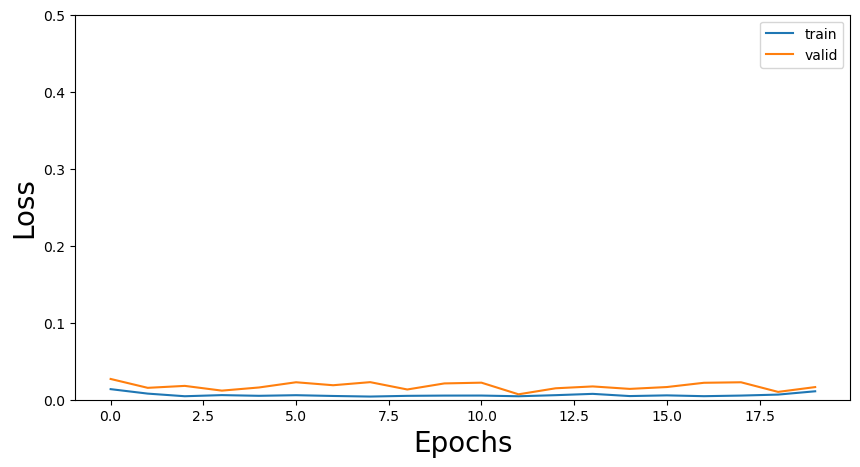

In [8]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs",size = 20)
plt.ylabel("Loss", size = 20)
plt.ylim(0,0.5)
plt.legend()
plt.show()

## Plot images from test set and compare distances

In [9]:
def show(img,ax,d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title("Dissimilarity:"+str(round(d[0],5)),fontweight = "bold", size = 24)
    ax.set_xticks([])
    ax.set_yticks([])

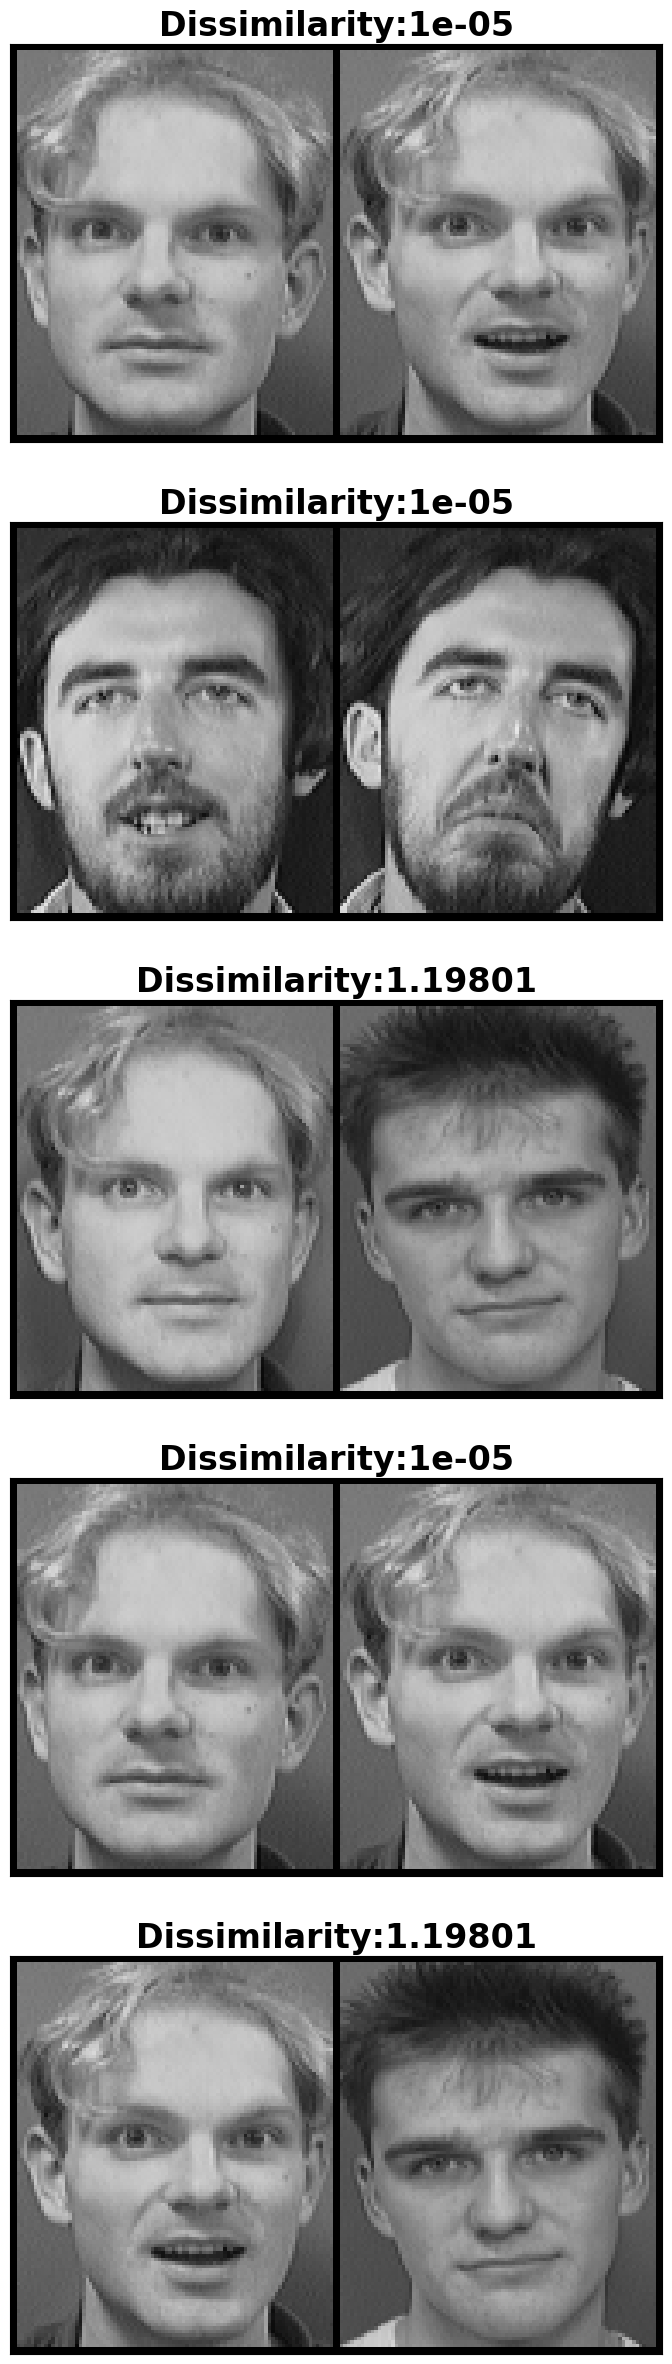

In [31]:
fig,ax = plt.subplots(5,1,figsize = (30,30))
for i in range(5):
    idx = np.random.randint(0,len(valid_ds))
    input1,input2,target = valid_ds[idx]
    model=model.to(device)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    grid = torchvision.utils.make_grid([input1,input2])
    euclidean_distance = F.pairwise_distance(output1,output2)
    
    show(grid,ax[i],euclidean_distance.cpu().detach().numpy())
plt.show()

In [11]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in train_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       156
           1       0.86      0.90      0.88       164

    accuracy                           0.88       320
   macro avg       0.88      0.87      0.87       320
weighted avg       0.88      0.88      0.87       320



In [34]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in test_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.89      0.94        27

    accuracy                           0.93        40
   macro avg       0.91      0.94      0.92        40
weighted avg       0.94      0.93      0.93        40



In [47]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in valid_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        30
           1       0.56      1.00      0.71        10

    accuracy                           0.80        40
   macro avg       0.78      0.87      0.78        40
weighted avg       0.89      0.80      0.81        40



## Save the trained model for future usage

In [48]:
torch.save(model.state_dict(),'./siameseNetowrk_final.pt')

In [49]:
new_model = SiameseNetwork()
new_model.load_state_dict(torch.load('./siameseNetowrk_final.pt'))
new_model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(